# Winton Stock Market Analysis

In [10]:
%pylab inline
import numpy as np
import tensorflow as tf
import pandas as pd
import keras as K

from keras.models import Sequential
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences

from IPython.display import display
from pprint import pprint as pp

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Preprocessing

In [2]:
train_raw = pd.read_csv('/dataset/winton-stock-market-challenge/train.csv')
test_raw = pd.read_csv('/dataset/winton-stock-market-challenge/test.csv')

In [3]:
FEATURE_INDICES = list(range(0, 25))
RET_MINUS_TWO = [25]
RET_MINUS_ONE = [26]
INTRADAY_X = list(range(27, 146))
INTRADAY_Y = list(range(146, 206))
INTRADAYS = INTRADAY_X + INTRADAY_Y

RET_PLUS_ONE = [206]
RET_PLUS_TWO = [207]
CUM_X = list(range(210, 329))
CUM_Y = list(range(329, 389))

먼저 nan을 처리하고, 필요 없는 columns (Id) 를 제거합니다.

In [4]:
train = train_raw.fillna(0)
train = train.drop(['Id'], axis=1)

### Cumulative Sum

Intraday returns (Ret_2 부터 Ret_180)의 cumulative sum을 구합니다. 

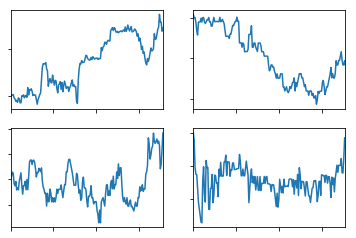

In [6]:
# Cumulative Sum Intraday returns
train[[f'cum_{i}' for i in range(2, len(INTRADAYS)+2)]]  = train[INTRADAYS].cumsum(axis=1)

# Visualization
f, ((ax1, ax2), (ax3, ax4))= subplots(2, 2)

ax1.tick_params(labelbottom='off', labelleft='off')
ax2.tick_params(labelbottom='off', labelleft='off')
ax3.tick_params(labelbottom='off', labelleft='off')
ax4.tick_params(labelbottom='off', labelleft='off')

def _p(ax): 
    train[CUM_X + CUM_Y].iloc[np.random.randint(1000)].plot(ax=ax)
    
_p(ax1); _p(ax2); _p(ax3); _p(ax4)

| Column | Index | train | Desciption |
|:-------|:-----:|:-----:|:-----------|
| Feature_1 | 0 | O | feature 첫번째 - 주가 예측에 영향을 주는 부분 |
| Feature_25 | 24 | O | feature 마지막 - 주가 예측에 영향을 주는 부분 | 
| Ret_MinusTwo | 25 | O | D-2의 폐장시점부터 D1의 폐장시점까지의 수익률입니다. (1 day) |
| Ret_MinusOne | 26 | O | D-1의 폐장시점부터 D의 일중 변동(Intraday returns)전까지의 수익률입니다. (대략 1/2 day) |
| Ret_2 | 27 | O | intraday 첫번째 - D의 특정시점의 대략적인 분단위 수익률입니다. Ret_2의 경우 t=1 과 t=2사이의 수익률입니다. |
| Ret_120 | 145 | O | intraday 마지막 - D의 특정시점의 대략적인 분단위 수익률입니다. Ret_2의 경우 t=1 과 t=2사이의 수익률입니다. | 
| Ret_121 | 146 | X | intraday 분단위 수익률 시작점 | 
| Ret_180 | 205 | X | intraday 분단위 수익률 마지막 | 
| Ret_PlusOne | 206 | X | Ret_180이 계산 종료된 시점부터 D+1의 폐장시점까지의 수익률입니다 (대략 1 day) |
| Ret_PlusTwo | 207 | X |  D+1의 폐장시점부터 D+2의 폐장시점까지의 수익률입니다. (1 day) |
| Weight_Intraday | 208 | X |  Ret_121 부터 Ret_180 까지의 일중 수익률을 계산시 사용한 가중치(weight)입니다. |
| Weight_Daily | 209 | X |   Ret_PlusOne 그리고 Ret_PlusTwo를 예측할때 사용한 가중치 (Weight)입니다. |
| cum_2 | 210 | O |   Ret_2의 cumsum |
| cum_120 | 328 | O |   Ret_120의 cumsum |
| cum_121 | 329 | X |   Ret_121의 cumsum |
| cum_180 | 388 | X |   Ret_180의 cumsum |

### Make Batch Data

x의 shape은 다음과 같습니다. (batch, 시간 t (119), features + cumulative stock (28))<br>
즉 예를 들어서

```
[[[ 0, 1, 2, ..., 27, 0.0],
  [ 0, 1, 2, ..., 27, 0.1],
  [ 0, 1, 2, ..., 27, 0.2],
  ...
  [ 0, 1, 2, ..., 27, 0.28],
```

features들은 모두 동일하고 끝의 cumulative stock부분만 변동이 됩니다.


In [12]:
# Make intraday input features
train_features = train[FEATURE_INDICES + RET_MINUS_TWO + RET_MINUS_ONE].as_matrix()
train_cuml_x = train[CUM_X].as_matrix()
train_cuml_y = train[CUM_Y].as_matrix()

N, N_FEATURE = train_features.shape # 40000, 27
N_CUM = train_cuml_x.shape[1] # 119

print(train_cuml_x.shape, train_cuml_y.shape)

train_features = train_features.reshape((-1, 1, N_FEATURE))
train_cuml_x = train_cuml.reshape((-1, N_CUM, 1))

train_intra_y = train_cuml_y.reshape((-1, ))
train_intra_x = np.zeros((N, N_CUM, N_FEATURE + 1))
for i, (f, c) in enumerate(zip(train_features, train_cuml)):
    train_intra_x[i, :, :-1] = f
    train_intra_x[i, :, -1:] = c

print(f'Train Intraday X: {train_intra_x.shape}')
print(f'Train Intraday X: {train_intra_y.shape}')

(40000, 119) (40000, 60)
Train Intraday X: (40000, 119, 28)
Train Intraday X: (2400000,)


In [39]:
def next_batch(data):
    features = data[FEATURE_INDICES]
    intra_cuml = data[CUM_X]
    
    
    
next_batch(train)

## Model

In [158]:
model = Sequential()
model.add(LSTM(output_dim=5, input_shape=()))

ValueError: The first layer in a Sequential model must get an `input_shape` or `batch_input_shape` argument.